## dataset
[] short sentenses are merge into long
[] doc packed per paragraph
[] 3 paragraphs build single sequence
[] sequence from sentences where seq_len is length of document - features include neighbors -2,-1,+1,+2 of entire document

In [52]:
import pandas as pd
import os,sys, imp
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import feature_utils
import defines
import numpy as np
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut,GroupKFold

from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import random
import model_utils
import seaborn as sns
import matplotlib.pyplot as plt


In [56]:
dir_name="recalc_tfidf"

In [57]:
db_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name)

In [58]:
imp.reload(doc_utils)
doc_db =  pd.read_csv("./dataframes/doc_db.csv")
doc_db.sort_values(by='doc_idx_from_name',inplace=True)
doc_db

,path,file_name,doc_idx_from_name,par_count,sent_count,nar_sent_count
0,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,01_aingimel3_lc.docx,1,205.000000,580.000000,256.000000
1,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,02_aingimel12_lc.docx,2,157.000000,632.000000,70.000000
2,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,03_aingimel26_lc.docx,3,118.000000,559.000000,102.000000
3,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,04_nun2_lc.docx,4,132.000000,460.000000,172.000000
4,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,05_kafhey_23_lc.docx,5,65.000000,510.000000,270.000000
...,...,...,...,...,...,...
75,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,76_nun2_Mor.docx,76,132.000000,464.000000,164.000000
76,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,77_nun25_Mor.docx,77,176.000000,406.000000,64.000000
77,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,78_tsadek27_Mor.docx,78,122.000000,178.000000,44.000000
78,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,79_tsadek29_Mor.docx,79,173.000000,252.000000,70.000000


In [60]:
imp.reload(feature_utils)
docs_map = feature_utils.pack_all_doc_sentences_to_map(dir_name,per_par=True,limit=0,doc_as_sequence=1,sent_lemma_db_list=[])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 14918 items packed for 80 docs


### Flow:
- Save doc names/statistic
- Parse doc
- Calculate POS
- Calculate vectors
- Calc tfidf
- Calculate similarity
- Save docs' features
- Proceed paragraphs (split long)
- Pask features to dictionary per doc/ per paragraph


In [62]:
docs_map[23]['X'][12]

[{'is_question': 0.0,
  'par_idx_in_doc': 12.0,
  'sent_len': 88.0,
  'is_client': 0,
  'sent_idx_in_par': 0,
  'TOKEN': 21,
  'POSTAG_BN': 0.0952380952380952,
  'POSTAG_DTT': 0.0476190476190476,
  'POSTAG_IN': 0.1904761904761904,
  'POSTAG_JJ': 0.0476190476190476,
  'POSTAG_MD': 0.0476190476190476,
  'POSTAG_PREPOSITION': 0.0476190476190476,
  'POSTAG_PRP': 0.3333333333333333,
  'POSTAG_QW': 0.0476190476190476,
  'POSTAG_RB': 0.1428571428571428,
  'POSTAG_REL': 0.0952380952380952,
  'POSTAG_S_PRN': 0.0952380952380952,
  'POSTAG_VB': 0.0476190476190476,
  'f_gen_F': 0.1904761904761904,
  'f_gen_M': 0.4285714285714285,
  'f_num_S': 0.6190476190476191,
  'f_per_1': 0.1904761904761904,
  'f_per_2': 0.0476190476190476,
  'f_per_3': 0.1904761904761904,
  'f_per_A': 0.1428571428571428,
  'sent_idx': 71,
  '-1:is_question': 0.0,
  '-1:par_idx_in_doc': 11.0,
  '-1:sent_len': 48.0,
  '-1:is_client': 1,
  '-1:sent_idx_in_par': 3,
  '-1:TOKEN': 11,
  '-1:POSTAG_COP': 0.0909090909090909,
  '-1:POS

In [7]:
imp.reload(feature_utils)
imp.reload(model_utils)
seq_len=3
step=3
per_par=True
feature_utils.reshape_docs_map_to_seq(docs_map,per_par,seq_len,step)

[67] 407 -> 136 [72] 420 -> 140 [58] 384 -> 128 [79] 172 -> 58 [53] 149 -> 50 [46] 200 -> 67 [11] 121 -> 41 [4] 132 -> 44 [25] 122 -> 41 [30] 82 -> 28 [23] 74 -> 25 [36] 87 -> 29 [9] 276 -> 92 [80] 223 -> 75 [28] 167 -> 56 [17] 322 -> 108 [2] 156 -> 52 [55] 249 -> 83 [40] 148 -> 50 [61] 433 -> 145 [74] 95 -> 32 [52] 275 -> 92 [47] 160 -> 54 [78] 122 -> 41 [59] 370 -> 124 [66] 366 -> 122 [73] 85 -> 29 [24] 158 -> 53 [31] 79 -> 27 [10] 123 -> 41 [5] 65 -> 22 [16] 102 -> 34 [3] 113 -> 38 [29] 105 -> 35 [8] 82 -> 28 [22] 89 -> 30 [37] 99 -> 33 [60] 245 -> 82 [75] 68 -> 23 [54] 243 -> 81 [41] 137 -> 46 [18] 62 -> 21 [32] 73 -> 25 [27] 67 -> 23 [6] 420 -> 140 [13] 90 -> 30 [39] 111 -> 37 [44] 199 -> 67 [51] 208 -> 70 [70] 183 -> 61 [65] 335 -> 112 [49] 206 -> 69 [76] 132 -> 44 [63] 338 -> 113 [42] 136 -> 46 [57] 271 -> 91 [68] 439 -> 147 [15] 121 -> 41 [34] 49 -> 17 [21] 108 -> 36 [38] 90 -> 30 [7] 248 -> 83 [12] 150 -> 50 [33] 91 -> 31 [26] 114 -> 38 [19] 265 -> 89 [71] 156 -> 52 [64] 347 -

In [8]:
docs_map[1].keys()

dict_keys(['X', 'y', 'groups', 'X_3_3', 'y_3_3', 'groups_3_3'])

### Run single example - sequence = 3x paragraph [1:3][4:6]...

In [9]:
import scipy
import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [10]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
num_splits=10
X_train,y_train,X_test,y_test,test_idx,groups_train,groups_test =  model_utils.split_test_train_docs(docs_map,test_percent,seq_len,step,seed)

In [11]:
%%time
# define fixed parameters and parameters to search
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


# rs.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 47min 41s, sys: 2min 40s, total: 50min 22s
Wall time: 50min 50s


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac243085220>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac2430a01c0>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [12]:
rs

RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac243085220>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac2430a01c0>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [13]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.12937159800007678, 'c2': 0.13620081180108615}
best CV score: 0.7988226331737124
model size: 1.99M


In [61]:
rs.cv_results_

{'mean_fit_time': array([10.62327043, 10.82455635, 10.44200611, 10.56543191, 10.66721519,
        10.32160052, 10.4027617 , 10.60232933, 10.37485218, 10.32527836,
        10.39524086, 10.25304588, 10.59785326, 10.44044248, 10.21805485,
         9.87040917,  9.69770288, 10.0134805 , 10.17359336,  9.88916906,
        10.18256124,  9.67448735, 10.10958989, 10.32298136, 10.08819469,
        10.11634676,  9.80039048,  9.92263905, 10.28927008, 10.09190599,
        10.10774151, 10.63780284,  9.83175532, 10.10288366, 10.10656706,
        10.60919348, 10.15824286, 10.20082211,  9.9084328 , 10.5541776 ,
        10.72278428, 10.10924363,  9.87238065,  9.90457829,  9.69128275,
        10.2669518 ,  9.76411637,  9.6657722 , 10.19347882, 10.25556127]),
 'std_fit_time': array([1.2840235 , 1.49077515, 1.3082894 , 1.67056631, 1.60422661,
        0.91062024, 0.95275184, 1.45382967, 1.49178328, 1.54453541,
        1.4220914 , 1.38487515, 1.75519712, 1.1896827 , 1.40928994,
        1.23664793, 1.24403496,

Dark blue => 0.7793, dark red => 0.7988


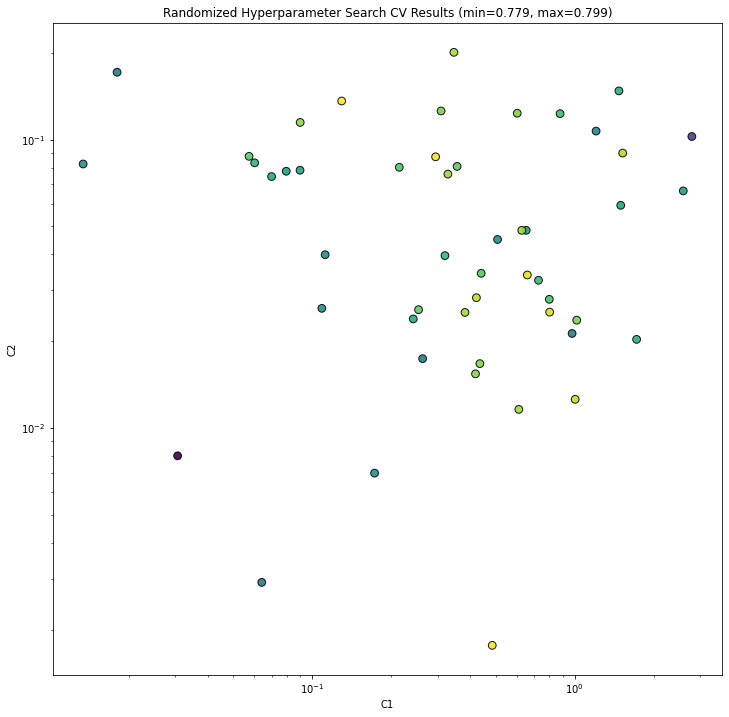

In [18]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [19]:
best_crf = rs.best_estimator_
y_pred  =  best_crf.predict(X_test)

              precision    recall  f1-score   support

      is_nar       0.71      0.58      0.64      2089
     not_nar       0.84      0.91      0.87      5227

    accuracy                           0.81      7316
   macro avg       0.78      0.74      0.76      7316
weighted avg       0.81      0.81      0.81      7316



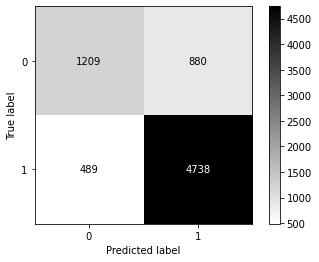

In [20]:
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),crf.classes_)

In [22]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(best_crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(best_crf.transition_features_).most_common()[-20:])

Top likely transitions:
is_nar -> is_nar  2.033938
not_nar -> not_nar 1.556495
not_nar -> is_nar  -1.478059
is_nar -> not_nar -1.738426

Top unlikely transitions:
is_nar -> is_nar  2.033938
not_nar -> not_nar 1.556495
not_nar -> is_nar  -1.478059
is_nar -> not_nar -1.738426


In [118]:
for item in docs_map[23]['X'][12][0].values():
    if (isinstance(item,numpy.int)):
        print (item)

NameError: name 'numpy' is not defined

In [110]:
import json
json.dumps(docs_map[23]['X'][12])

TypeError: Object of type int64 is not JSON serializable

In [24]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(best_crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(best_crf.state_features_).most_common()[-30:])

Top positive:
2.684488 is_nar   tfidf_word_2141
2.553954 is_nar   tfidf_word_6265
2.461594 is_nar   tfidf_word_1924
2.346703 is_nar   tfidf_word_3175
2.317286 not_nar  tfidf_word_5752
2.267719 is_nar   tfidf_word_9303
2.149579 not_nar  tfidf_word_8514
2.056090 is_nar   tfidf_word_410
2.035053 not_nar  tfidf_word_2812
2.017552 is_nar   tfidf_word_6329
1.993347 is_nar   tfidf_word_3402
1.969718 not_nar  tfidf_word_7692
1.965252 is_nar   tfidf_word_7453
1.936832 not_nar  tfidf_word_5823
1.914674 is_nar   tfidf_word_7915
1.896586 is_nar   tfidf_word_5132
1.870204 not_nar  tfidf_word_5441
1.867879 is_nar   tfidf_word_881
1.829217 is_nar   tfidf_word_4568
1.771939 is_nar   tfidf_word_3797
1.764985 is_nar   tfidf_word_7364
1.764878 not_nar  tfidf_word_4206
1.733613 is_nar   tfidf_word_4593
1.720932 not_nar  tfidf_word_8368
1.713315 not_nar  tfidf_char_wb_12145
1.694959 not_nar  tfidf_word_9495
1.688156 is_nar   tfidf_word_4716
1.674929 is_nar   tfidf_word_8773
1.663441 is_nar   tfidf_word_341